<a href="https://colab.research.google.com/github/dshan805/monet_cycle_gan/blob/main/monet_cycle_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Monet Image Generation

## Purpose
The purpose of this challenge is to build a GAN (Generative Adeversarial Network) to transform given photos into they style of Claude Monet's paintings. By focusing on th unique artistic features of Monet's painting, the goal is to produce image that could plausibly be mistaken for Monet paintings by discrimnator part of GAN.

## Data
* **Monet Paintings**: THe dataset includes 300 of Monet's paintings.
    * JPEG and TFRecord Format are available
* **Photos**: Photos that could be tranformed into Monet's style are also provided. There are 7028 photos sized 256x256 in TFRecord format.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Model, Input, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Concatenate, LeakyReLU, Activation, BatchNormalization
from tensorflow.keras.layers import Input, Concatenate, Conv2D, Conv2DTranspose, LeakyReLU, ReLU, BatchNormalization, Dropout, ZeroPadding2D
from tensorflow.keras.losses import BinaryCrossentropy
from PIL import Image
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import zipfile
import os

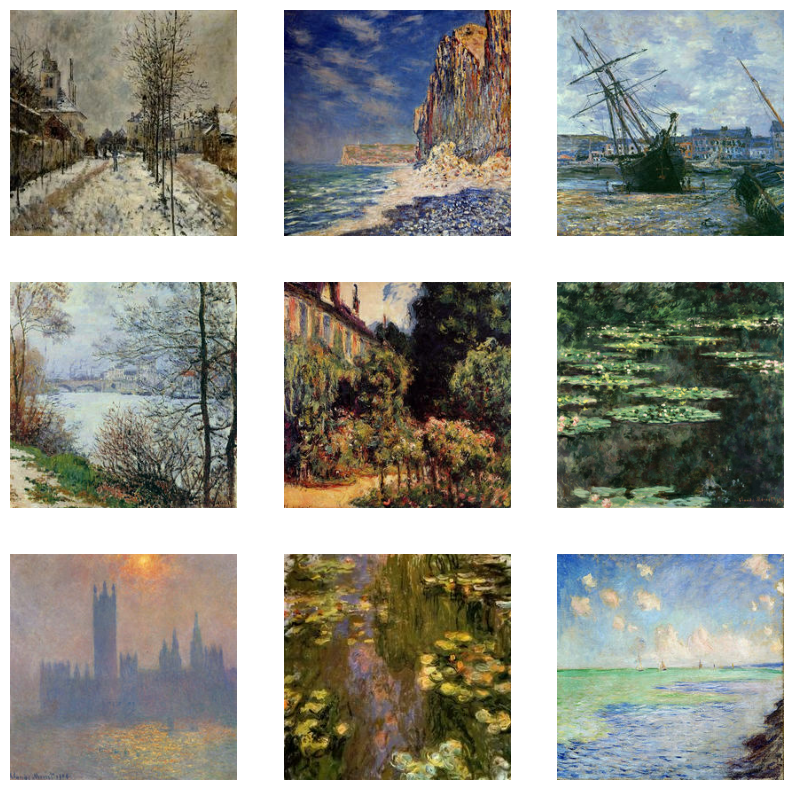

In [4]:
monet_filenames = tf.io.gfile.glob('/content/drive/MyDrive/ColabNotebooks/DTSA5511/monet_cycle_gan/monet_tfrec/*.tfrec')

feature_description = {
    'image': tf.io.FixedLenFeature([], tf.string),
}

def parse_tfrecord_fn(example):
    example = tf.io.parse_single_example(example, feature_description)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    return image

monet_dataset = tf.data.TFRecordDataset(monet_filenames)
monet_dataset = monet_dataset.map(parse_tfrecord_fn)

# Display a few images
def display_images(dataset):
    plt.figure(figsize=(10, 10))
    for i, image in enumerate(dataset.take(9)):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image)
        plt.axis("off")
    plt.show()

display_images(monet_dataset)

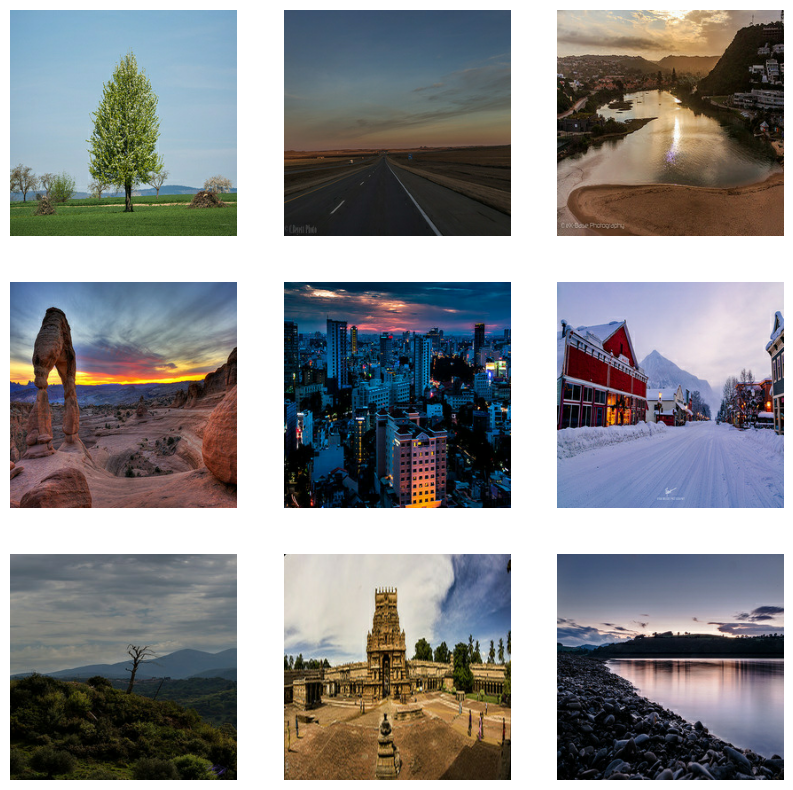

In [5]:
photo_filenames = tf.io.gfile.glob('/content/drive/MyDrive/ColabNotebooks/DTSA5511/monet_cycle_gan/photo_tfrec/*.tfrec')

feature_description = {
    'image': tf.io.FixedLenFeature([], tf.string),
}

photo_dataset = tf.data.TFRecordDataset(photo_filenames)
photo_dataset = photo_dataset.map(parse_tfrecord_fn)

# Display a few images
def display_images(dataset):
    plt.figure(figsize=(10, 10))
    for i, image in enumerate(dataset.take(9)):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image)
        plt.axis("off")
    plt.show()

display_images(photo_dataset)

## Data Exploration

### Brightness Distribution

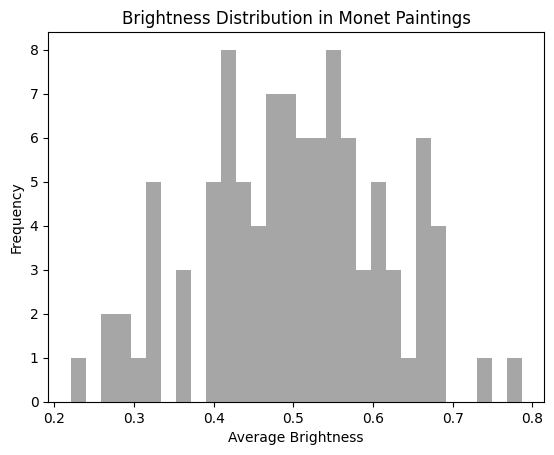

In [32]:
def plot_brightness_distribution(dataset):
    brightness_values = []
    for image in dataset.take(100):
        brightness = tf.reduce_mean(image).numpy()
        brightness_values.append(brightness)

    plt.hist(brightness_values, bins=30, color='gray', alpha=0.7)
    plt.title('Brightness Distribution in Monet Paintings')
    plt.xlabel('Average Brightness')
    plt.ylabel('Frequency')
    plt.show()

plot_brightness_distribution(monet_dataset)

### Texture and Pattern Analysis

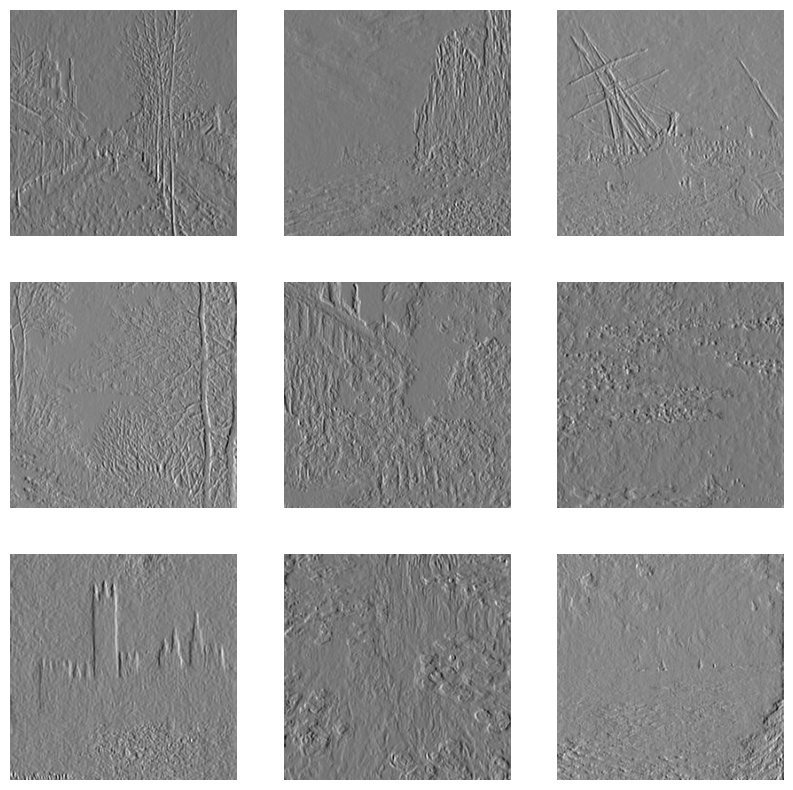

In [33]:
import cv2
from scipy import ndimage

def display_texture_edges(dataset):
    plt.figure(figsize=(10, 10))
    for i, image in enumerate(dataset.take(9)):
        # Convert to grayscale for edge detection
        gray = tf.image.rgb_to_grayscale(image)
        # Use Sobel edge detection
        sobel = ndimage.sobel(gray.numpy().squeeze())

        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(sobel, cmap='gray')
        plt.axis("off")
    plt.show()

display_texture_edges(monet_dataset)


## Model Architecture

For the task of transforming photos into Monet-style paintings, a CycleGAN architecture is suitable. CycleGAN allows for image-to-image translation in an unpaired setting, which is ideal for this challenge since we do not have direct correspondences between specific photos and Monet paintings.

### CycleGAN Architecture

#### Generator:

**Architecture:** The generator in a CycleGAN typically uses a U-Net architecture, which consists of an encoder-decoder with skip connections. The encoder progressively downsamples the input image, capturing high-level features at various scales. The decoder then upsamples these features to construct the output image, with skip connections helping to preserve fine details.

#### Discriminator:

**Architecture:** The discriminator is a PatchGAN classifier. It classifies whether small patches of the image are real or fake, rather than making a judgment on the image as a whole.



### Generator

In [6]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
      Conv2D(filters, size, strides=2, padding='same',
             kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(BatchNormalization())
    result.add(LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
      Conv2DTranspose(filters, size, strides=2,
                      padding='same',
                      kernel_initializer=initializer,
                      use_bias=False))
    result.add(BatchNormalization())
    if apply_dropout:
        result.add(Dropout(0.5))
    result.add(ReLU())
    return result

def Generator():
    inputs = Input(shape=[256,256,3])
    down_stack = [
      downsample(64, 4, apply_batchnorm=False),
      downsample(128, 4),
      downsample(256, 4),
      downsample(512, 4),
      downsample(512, 4),
      downsample(512, 4),
      downsample(512, 4),
      downsample(512, 4),
    ]
    up_stack = [
      upsample(512, 4, apply_dropout=True),
      upsample(512, 4, apply_dropout=True),
      upsample(512, 4, apply_dropout=True),
      upsample(512, 4),
      upsample(256, 4),
      upsample(128, 4),
      upsample(64, 4),
    ]
    initializer = tf.random_normal_initializer(0., 0.02)
    last = Conv2DTranspose(3, 4,
                           strides=2,
                           padding='same',
                           kernel_initializer=initializer,
                           activation='tanh')

    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = Concatenate()([x, skip])
    x = last(x)
    return Model(inputs=inputs, outputs=x)

### Discriminator

In [7]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = Input(shape=[256, 256, 3], name='input_image')
    x = inp
    down1 = downsample(64, 4, False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)
    zero_pad1 = ZeroPadding2D()(down3)
    conv = Conv2D(512, 4, strides=1,
                  kernel_initializer=initializer,
                  use_bias=False)(zero_pad1)
    batchnorm1 = BatchNormalization()(conv)
    leaky_relu = LeakyReLU()(batchnorm1)
    zero_pad2 = ZeroPadding2D()(leaky_relu)
    last = Conv2D(1, 4, strides=1,
                  kernel_initializer=initializer)(zero_pad2)
    return tf.keras.Model(inputs=inp, outputs=last)

### Define Loss Functions and Optimizers

In [8]:
generator_optimizer = Adam(2e-4, beta_1=0.5)
discriminator_optimizer = Adam(2e-4, beta_1=0.5)

loss_obj = BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

### Training

In [9]:
# Assuming `Generator()` and `Discriminator()` functions are defined as per your script
generator_g = Generator()  # Photo to Monet
generator_f = Generator()  # Monet to Photo
discriminator_x = Discriminator()  # Discriminator for Photos
discriminator_y = Discriminator()  # Discriminator for Monet

# Optimizers
generator_g_optimizer = Adam(2e-4, beta_1=0.5)
generator_f_optimizer = Adam(2e-4, beta_1=0.5)
discriminator_x_optimizer = Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = Adam(2e-4, beta_1=0.5)

# Loss functions
loss_obj = BinaryCrossentropy(from_logits=True)

def cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return 10 * loss1

def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return 0.5 * 10 * loss

@tf.function
def train_step(real_x, real_y):
    # persistent is set to True because GradientTape is used more than once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        # Generator F translates Y -> X
        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        # Identity mapping
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        # Discriminator output
        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)
        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # Generator adversarial loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        # Total cycle consistency loss
        total_cycle_loss = cycle_loss(real_x, cycled_x) + cycle_loss(real_y, cycled_y)

        # Total generator loss = adversarial loss + cycle loss + identity loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        # Discriminator loss
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Calculate the gradients for generators and discriminators
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)
    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

    # Apply the gradients to the optimizers
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

def train(monet_dataset, photo_dataset, epochs):
    for epoch in range(epochs):
        n = 0
        for image_x, image_y in tf.data.Dataset.zip((photo_dataset, monet_dataset)):
            train_step(image_x, image_y)
            if n % 10 == 0:
                print('.', end='')
            n += 1
        print()
        print(f"Epoch {epoch + 1}/{epochs} finished")




In [11]:
# Prepare datasets
BATCH_SIZE = 1
monet_dataset = monet_dataset.batch(BATCH_SIZE)
photo_dataset = photo_dataset.batch(BATCH_SIZE)

# Training the model
# Specify the number of epochs
EPOCHS = 50
train(monet_dataset, photo_dataset, EPOCHS)

..............................
Epoch 1/50 finished
..............................
Epoch 2/50 finished
..............................
Epoch 3/50 finished
..............................
Epoch 4/50 finished
..............................
Epoch 5/50 finished
..............................
Epoch 6/50 finished
..............................
Epoch 7/50 finished
..............................
Epoch 8/50 finished
..............................
Epoch 9/50 finished
..............................
Epoch 10/50 finished
..............................
Epoch 11/50 finished
..............................
Epoch 12/50 finished
..............................
Epoch 13/50 finished
..............................
Epoch 14/50 finished
..............................
Epoch 15/50 finished
..............................
Epoch 16/50 finished
..............................
Epoch 17/50 finished
..............................
Epoch 18/50 finished
..............................
Epoch 19/50 finished
.....................

### Generate Images

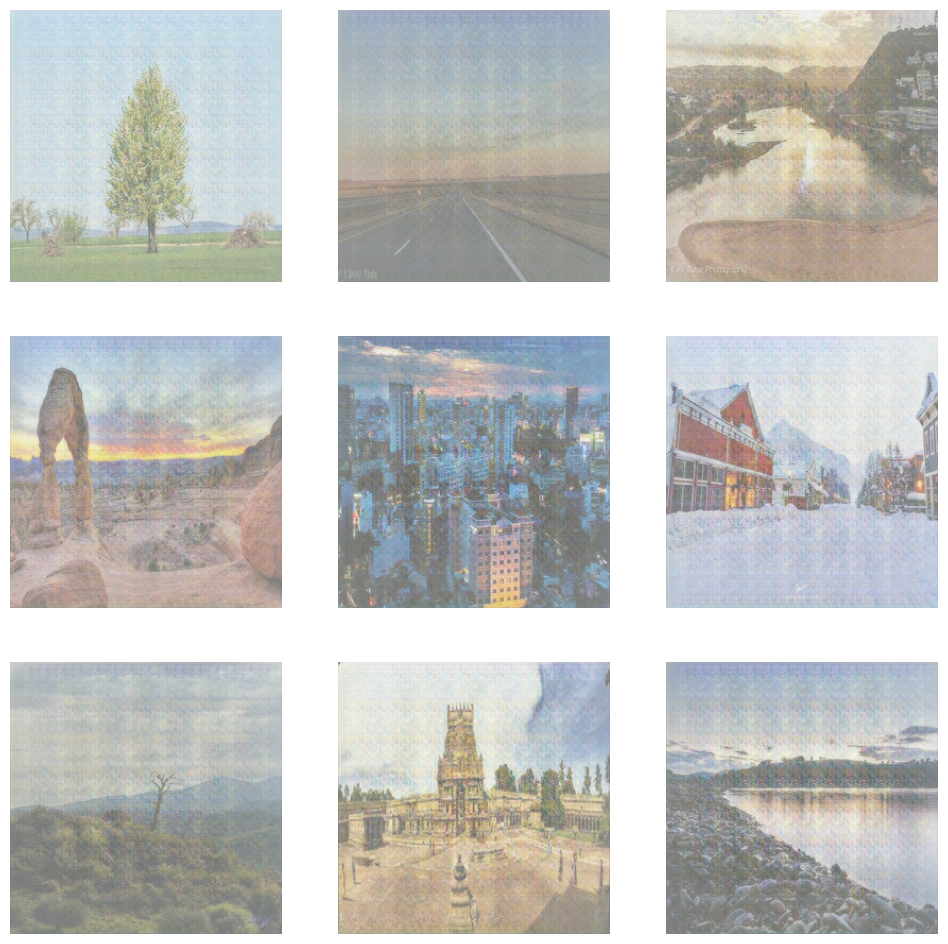

In [15]:
def generate_images(model, test_input, n_images=9):
    plt.figure(figsize=(12, 12))
    for i, img in enumerate(test_input.take(n_images)):
        prediction = model(img, training=False)[0].numpy()
        prediction = (prediction * 0.5) + 0.5  # Rescale to [0, 1]
        plt.subplot(3, 3, i+1)
        plt.imshow(prediction)
        plt.axis('off')
    plt.show()

generate_images(generator_g, photo_dataset)


In [20]:
def save_images_and_zip(model, dataset, n_images=7000, output_dir="generated_images", zip_path="images.zip"):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Generate and save images
    for i, (img,) in enumerate(dataset.take(n_images)):  # Note the change here to unpack the batch
        prediction = model(img, training=False)[0].numpy()  # img is now correctly shaped as (256, 256, 3)
        prediction = (prediction * 0.5 + 0.5) * 255  # Rescale to [0, 255]
        prediction = tf.cast(prediction, tf.uint8)
        file_path = os.path.join(output_dir, f"monet_{i+1}.jpg")
        tf.keras.preprocessing.image.save_img(file_path, prediction)

    # Zip the directory
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, _, files in os.walk(output_dir):
            for file in files:
                zipf.write(os.path.join(root, file), arcname=file)

    print(f"Saved and zipped {n_images} images to {zip_path}")

# Adjust the dataset batch size if necessary
photo_dataset_batched = photo_dataset.batch(1)

# Generate, save, and zip images with the specified ZIP file name
save_images_and_zip(generator_g, photo_dataset_batched, 7000, zip_path="images.zip")


Saved and zipped 7000 images to images.zip
